## Model Evaluation

We'll now evaluate or model and see how it performs against a testing and cross-validation data set.

First, load the model:

In [53]:
%load_ext autoreload
%autoreload 2

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from feature_util import load_model_pickle

model = load_model_pickle('models/ipr_model_202408180449.pkl')

In [3]:
model.feature_names_in_

array(['line_count', 'msrp', 'trading_partner_cn', 'trading_partner_hk',
       'trading_partner_other_countries', 'trading_partner_sg',
       'trading_partner_tr'], dtype=object)

With the model loaded now we'll evaluate its performance against a triaining set:

In [4]:
from feature_util import load_split

y_name = 'seized'

X_train, y_train = load_split('data/processed/ipr_data_processed_train.csv', y_name)
X_test, y_test = load_split('data/processed/ipr_data_processed_test.csv', y_name)
X_cv, y_cv = load_split('data/processed/ipr_data_processed_cv.csv', y_name)

In [5]:
X_test, y_test

(       line_count     msrp  trading_partner_cn  trading_partner_hk  \
 0               8   4620.0                   0                   0   
 1              89  30690.0                   1                   0   
 2             166  22400.0                   1                   0   
 3               6  11000.0                   0                   1   
 4              14   3120.0                   0                   0   
 ...           ...      ...                 ...                 ...   
 66612           1  19990.0                   0                   1   
 66613           2  88800.0                   1                   0   
 66614          23   1125.0                   0                   0   
 66615          71     24.0                   1                   0   
 66616          41    295.0                   0                   0   
 
        trading_partner_other_countries  trading_partner_sg  trading_partner_tr  
 0                                    0                   0     

In [6]:
scores = model.score_samples(X_test)
scores

array([12.78173742,  0.        ,  0.        , ..., 14.26912733,
        4.70233679,  3.43884422])

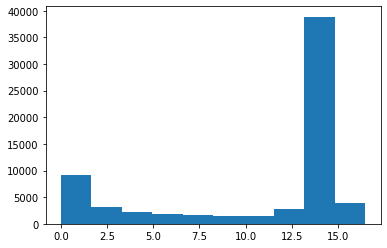

In [7]:
import matplotlib.pyplot as plt

plt.hist(scores);

In [8]:
import numpy as np

np.save('models/ipr_model_20240817.1', scores)

Lets also look at the classification report:

In [12]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         1.0       1.00      0.40      0.57     66617

    accuracy                           0.40     66617
   macro avg       0.50      0.20      0.28     66617
weighted avg       1.00      0.40      0.57     66617



Next we'lll use the model on our company's product list

In [66]:
from etl_hvi_data import load_processed

hvi_processed_df = load_processed()
hvi_processed_df = hvi_processed_df[model.feature_names_in_]

print("Total Records", len(hvi_processed_df))
hvi_processed_df.describe()

Total Records 4200


,line_count,msrp,trading_partner_cn,trading_partner_hk,trading_partner_other_countries,trading_partner_sg,trading_partner_tr
count,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000
mean,121.571429,24.713262,0.166667,0.166667,0.166667,0.166667,0.166667
std,253.094131,20.247834,0.372722,0.372722,0.372722,0.372722,0.372722
min,1.000000,4.767025,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,11.935484,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,17.909200,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,30.101553,0.000000,0.000000,0.000000,0.000000,0.000000
max,740.000000,143.369176,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
seized_pred = model.predict(hvi_processed_df)
seized_pred

array([-1,  1, -1, ..., -1, -1, -1])

In [78]:
hvi_risk_df = hvi_processed_df.copy()
hvi_risk_df['seized_pred'] = seized_pred

In [79]:
hvi_risk_df.describe()

,line_count,msrp,trading_partner_cn,trading_partner_hk,trading_partner_other_countries,trading_partner_sg,trading_partner_tr,seized_pred
count,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000
mean,121.571429,24.713262,0.166667,0.166667,0.166667,0.166667,0.166667,-0.489048
std,253.094131,20.247834,0.372722,0.372722,0.372722,0.372722,0.372722,0.872361
min,1.000000,4.767025,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,3.000000,11.935484,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,19.000000,17.909200,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
75%,56.000000,30.101553,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,740.000000,143.369176,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
hvi_risk_df.seized_pred.describe()

count    4200.000000
mean       -0.489048
std         0.872361
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max         1.000000
Name: seized_pred, dtype: float64

In [81]:
hvi_risk_df.seized_pred.value_counts()

seized_pred
-1    3127
 1    1073
Name: count, dtype: int64

Before we save to disk, we'll convert back the dummy or one-hot encoded trading partner columns to a categorical one:

In [82]:
trading_partner_columns = [c for c in hvi_risk_df.columns if c.startswith("trading_partner_")]
trading_partner_values = [' '.join(c.split("_")[2:]) for c in trending_partner_columns]

print(trading_partner_columns)
print(trading_partner_values)

['trading_partner_cn', 'trading_partner_hk', 'trading_partner_other_countries', 'trading_partner_sg', 'trading_partner_tr']
['cn', 'hk', 'other countries', 'sg', 'tr']


In [85]:
def trading_partner_categorical(x):
    """
    Reverse encodes categorical values from dummy / OHE features to categorical labels
    """
    try:
        index = list(x[trending_partner_columns]).index(1)
    except:
        index = -1
    trading_partner = trading_partner_values[index] if index != -1 else 'ca'
    return trading_partner

hvi_risk_df['trading_partner'] = hvi_risk_df.apply(trading_partner_categorical, axis='columns')

In [86]:
hvi_risk_df.columns

Index(['line_count', 'msrp', 'trading_partner_cn', 'trading_partner_hk',
       'trading_partner_other_countries', 'trading_partner_sg',
       'trading_partner_tr', 'seized_pred', 'trading_partner'],
      dtype='object')

In [87]:
hvi_risk_df.trading_partner.describe()

count     4200
unique       6
top         cn
freq       700
Name: trading_partner, dtype: object

In [88]:
hvi_risk_df.drop(columns=trading_partner_columns, inplace=True)

In [89]:
hvi_risk_df.columns

Index(['line_count', 'msrp', 'seized_pred', 'trading_partner'], dtype='object')

Finally, now that we've run our model we can get an estimate of risk, the model will have predicted whether an particular product would've been seized or not and we'll use the sum of those seized vs not as the risk indicator

  * `-1` -> Inliner or seized
  * `1` -> Outlier or not seized

To make it easier to identify we'll replace the values with values that simplify categorical and numerical opertions,

  * `1` -> Seized
  * `0` -> Not Seized

In [90]:
hvi_risk_df['seized_pred'] = hvi_risk_df.seized_pred.apply(lambda x: 0 if x == 1 else 1)

In [91]:
hvi_risk_df.drop(columns=[1, -1], inplace=True, errors='ignore')

In [92]:
hvi_risk_df.describe()

,line_count,msrp,seized_pred
count,4200.000000,4200.000000,4200.000000
mean,121.571429,24.713262,0.744524
std,253.094131,20.247834,0.436180
min,1.000000,4.767025,0.000000
25%,3.000000,11.935484,0.000000
50%,19.000000,17.909200,1.000000
75%,56.000000,30.101553,1.000000
max,740.000000,143.369176,1.000000


In [93]:
hvi_risk_df.seized_pred.value_counts()

seized_pred
1    3127
0    1073
Name: count, dtype: int64

Finally, we'll save merge our risk dataset with the original product items to be able to draw conclusions from the risk profiles

In [94]:
from etl_hvi_data import load_processed

hvi_products = load_processed()
hvi_products_temp_df = pd.concat([hvi_risk_df, hvi_products[['product_id', 'brand_name']]], axis='columns')
hvi_processed_df = hvi_products_temp_df[['product_id', 'brand_name', 'trading_partner', 'line_count', 'msrp', 'seized_pred']]
hvi_processed_df.head()


,product_id,brand_name,trading_partner,line_count,msrp,seized_pred
0,2296012,Roadster,cn,24,17.909200,1
1,13780156,LOCOMOTIVE,cn,24,13.727599,0
2,11895958,Roadster,cn,24,16.714456,1
3,4335679,Zivame,cn,24,15.471924,1
4,11690882,Roadster,cn,24,7.156511,1


In [95]:
hvi_processed_df.to_csv("data/processed/hvi_products_risk.csv", index=False)